In [1]:
import mlflow
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import warnings
warnings.filterwarnings("ignore")

2023-08-07 09:57:49.408301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-07 09:57:49.408351: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# EZAF_ENV = "hpe-gse-ezaf"
# token_url = f"https://keycloak.{EZAF_ENV}.com/realms/UA/protocol/openid-connect/token"

# data = {
#     "username" : "hpedemo-user01",#input("Enter username."),
#     "password" : "Hpepoc@123",#input("Enter password."),
#     "grant_type" : "password",
#     "client_id" : "ua-grant",
# }

# token_responce = requests.post(token_url, data=data, allow_redirects=True, verify=False)

# token = token_responce.json()["access_token"]

# minio_username = "minioadmin"
# minio_password = "minioadmin"

In [4]:
# Set up an experiment with set_exp from ezmllib.mlflow
experiment_name = 'stock-exp-1'
mlflow.set_experiment(exp_name)
mlflow.tensorflow.autolog()

In [6]:
def preprocess_data(df,start_date,end_date):
    #df=df[['Date','Open','Close']]
    df = df.loc[(df["Date"]>=start_date) & (df["Date"]<=end_date)]  
    df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d").dt.date
    df=df.set_index("Date")
    df.index.freq = 'D' 
    
    date_range = pd.DataFrame(pd.date_range(start=start_date, end=end_date),columns=["Date"])
    date_range['Date'] = date_range['Date'].dt.date
    date_range=date_range.set_index("Date")
    date_range.index.freq = 'D'
    
    df = pd.merge(date_range, df, how='left',left_index=True, right_index=True).fillna(method = 'ffill')
    df.dropna(inplace=True)
    return df

# EDA Plots

In [9]:
df=pd.read_csv("datasets/ASIANPAINT.csv")
df = preprocess_data(df,"2000-01-03","2019-12-31")
df["Year"]=pd.DatetimeIndex(df.index).year

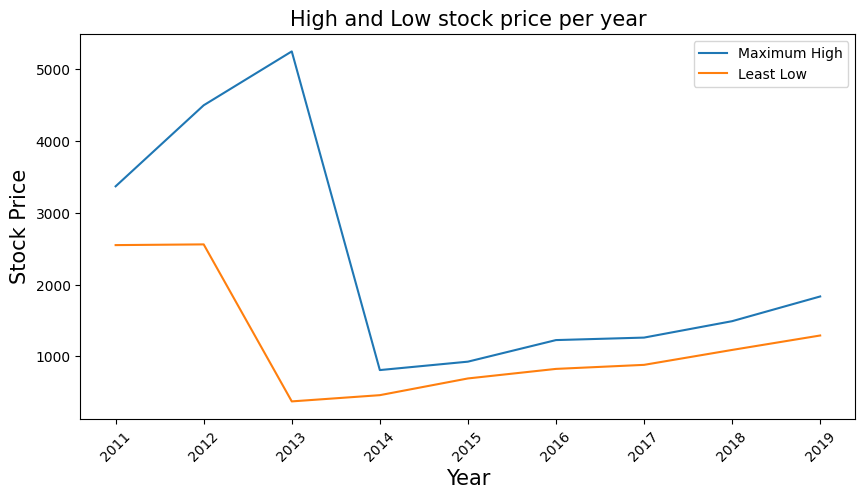

In [10]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(df.groupby("Year").max()["High"],label='Maximum High')
ax.plot(df.groupby("Year").min()["Low"],label='Least Low')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Year',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('High and Low stock price per year',size=15)
ax.legend()
fg.show()

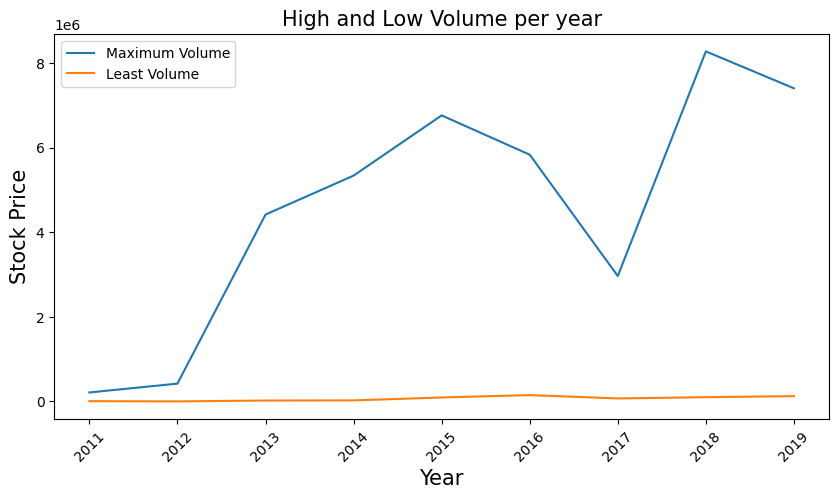

In [11]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(df.groupby("Year").max()["Volume"],label='Maximum Volume')
ax.plot(df.groupby("Year").min()["Volume"],label='Least Volume')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Year',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('High and Low Volume per year',size=15)
ax.legend()
fg.show()

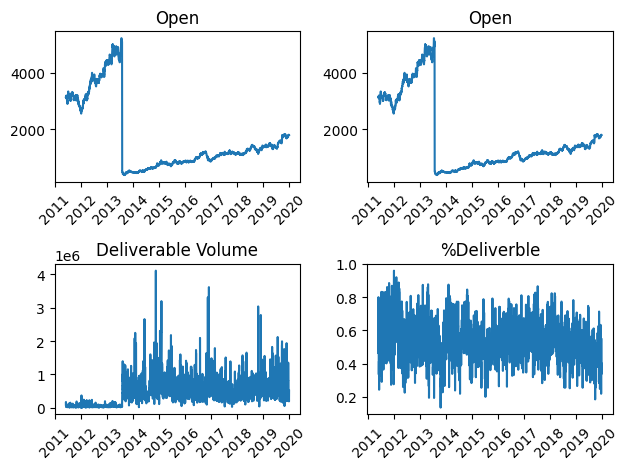

In [12]:
figure, axis = plt.subplots(2,2)

axis[0,0].plot(df["Open"])
axis[0,0].set_title("Open")
plt.setp(axis[0,0].xaxis.get_majorticklabels(), rotation=45)

axis[0,1].plot(df["Open"])
axis[0,1].set_title("Open")
plt.setp(axis[0,1].xaxis.get_majorticklabels(), rotation=45)

axis[1,0].plot(df["Deliverable Volume"])
axis[1,0].set_title("Deliverable Volume")
plt.setp(axis[1,0].xaxis.get_majorticklabels(), rotation=45)

axis[1,1].plot(df["%Deliverble"])
axis[1,1].set_title("%Deliverble")
plt.setp(axis[1,1].xaxis.get_majorticklabels(), rotation=45)
figure.tight_layout()

# Model Building

In [7]:
def create_sequence(dataset):
    sequences = []
    labels = []

    start_idx = 0

    for stop_idx in range(60,len(dataset)): 
        sequences.append(dataset.iloc[start_idx:stop_idx])
        labels.append(dataset.iloc[stop_idx])
        start_idx += 1
    return (np.array(sequences),np.array(labels))

In [8]:
def model_definition(rows,cols):
    model = Sequential()
    model.add(LSTM(units=60, return_sequences=True, input_shape = (rows,cols)))
    model.add(Dropout(0.1)) 
    model.add(LSTM(units=60))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

# def model_definition(rows,cols):
#     model = Sequential()
#     model.add(LSTM(units=60, return_sequences=True, input_shape = (rows,cols)))
#     model.add(Dropout(0.1)) 
#     model.add(LSTM(units=60,return_sequences=True))
#     model.add(Dropout(0.1)) 
#     model.add(LSTM(units=60))
#     model.add(Dense(2))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
#     return model

# def model_definition(rows,cols):
#     model = Sequential()
#     model.add(LSTM(units=30, return_sequences=True, input_shape = (rows,cols)))
#     model.add(Dropout(0.1)) 
#     model.add(LSTM(units=30,return_sequences=True))
#     model.add(Dropout(0.1)) 
#     model.add(LSTM(units=30))
#     model.add(Dense(2))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
#     return model

In [13]:
df=pd.read_csv("datasets/ASIANPAINT.csv")
df = preprocess_data(df,"2014-01-01","2019-12-31")
df=df[['Open','Close']]

In [14]:
scale = MinMaxScaler()
df[df.columns] = scale.fit_transform(df)
training_size = round(len(df) * 0.80)
train_data = df[:training_size]
test_data  = df[training_size:]

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

model = model_definition(train_seq.shape[1], train_seq.shape[2])
model.summary()

2023-08-07 09:57:53.998294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-07 09:57:53.998343: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-07 09:57:53.998381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (banking-poc-0): /proc/driver/nvidia/version does not exist
2023-08-07 09:57:53.998768: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            15120     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 2)                 122       
                                                                 
Total params: 44,282
Trainable params: 44,282
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(train_seq, train_label, epochs=5,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/5
53/53 [==============================] - 11s 133ms/step - loss: 0.0115 - mean_absolute_error: 0.0637 - val_loss: 0.0030 - val_mean_absolute_error: 0.0433
Epoch 2/5
53/53 [==============================] - 6s 109ms/step - loss: 5.1820e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0016 - val_mean_absolute_error: 0.0298
Epoch 3/5
53/53 [==============================] - 6s 114ms/step - loss: 4.6953e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 4/5
53/53 [==============================] - 6s 118ms/step - loss: 5.0046e-04 - mean_absolute_error: 0.0172 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334
Epoch 5/5
53/53 [==============================] - 6s 116ms/step - loss: 4.5856e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0020 - val_mean_absolute_error: 0.0346


2023-08-07 09:58:33.315538: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp6ldeq__i/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ldeq__i/model/data/model/assets


In [ ]:
mlflow.search_runs(order_by=['metrics.mean_absolute_error ASC'])

In [ ]:
best_run_df = mlflow.search_runs(order_by=['metrics.mean_absolute_error ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.tensorflow.load_model(best_model_uri)

In [ ]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: mean_absolute_error = {:.4f}\n\n".format(best_run.data.metrics['mean_absolute_error']))
print(f"Run model URI: {best_model_uri}")

In [ ]:
model=best_model

In [ ]:
test_predicted = model.predict(test_seq)
test_inverse_predicted = scale.inverse_transform(test_predicted)
new_df = pd.concat([df.iloc[-len(test_predicted):].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=df.iloc[-len(test_predicted):].index)], axis=1)
new_df[['Open','Close']] = scale.inverse_transform(new_df[['Open','Close']])
new_df.head()

In [ ]:
new_df[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

In [ ]:
new_df[['Close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

# KServe

In [ ]:
signature = mlflow.models.signature.infer_signature(test_seq, test_label)
mlflow_tf_model_save_path_backup = mlflow.tensorflow._MODEL_SAVE_PATH
mlflow.tensorflow._MODEL_SAVE_PATH += "/1"
model_info = mlflow.tensorflow.log_model(model=model, artifact_path="model", signature=signature, registered_model_name="stock_price_1")
mlflow.tensorflow._MODEL_SAVE_PATH = mlflow_tf_model_save_path_backup

saved_model_path = os.path.join(mlflow.get_run(model_info.run_id).info.artifact_uri, model_info.artifact_path, "data", mlflow.tensorflow._MODEL_SAVE_PATH)

In [ ]:
import yaml
# Create inferenceservice for trained model
with open('./yaml_files/stock_inferenceservice.yaml', 'r') as file:
    inferenceservice_yaml_data = yaml.safe_load(file)

inferenceservice_yaml_data["spec"]["predictor"]["tensorflow"]["storageUri"] = saved_model_path

with open('./yaml_files/stock_inferenceservice.yaml', 'w') as yaml_file:
    yaml.dump(inferenceservice_yaml_data, yaml_file)

!kubectl apply -f /mnt/user/banking_poc/yaml_files/stock_inferenceservice.yaml

## Check if inference service is running

In [ ]:
!until kubectl get pods -l serving.kserve.io/inferenceservice=stock-exp-1 | grep -q "Running"; do sleep 10; done
!echo "Inferenceservice is running"
!kubectl wait --for=condition=ready pod -l serving.kserve.io/inferenceservice=stock-exp-1 --timeout=600s

In [ ]:
URL = f"http://stock-exp-1-predictor-default.{os.getenv('JUPYTERHUB_USER')}.svc.cluster.local/v1/models/stock-exp-1:predict"
print(URL)
headers = {"Authorization": f"Bearer {os.environ['AUTH_TOKEN']}"}
inputs = {"inputs": test_seq.tolist()}
response = requests.post(URL, json=inputs, headers=headers)
print(response)

In [110]:
test_predicted = response.json()["outputs"]

test_inverse_predicted = scale.inverse_transform(test_predicted)
new_df = pd.concat([df.iloc[-len(test_predicted):].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=df.iloc[-len(test_predicted):].index)], axis=1)
new_df[['Open','Close']] = scale.inverse_transform(new_df[['Open','Close']])
new_df.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2018-12-19,1370.0,1400.25,1309.510039,1319.306189
2018-12-20,1389.9,1425.80,1313.208385,1322.894531
2018-12-21,1433.9,1388.20,1318.839103,1328.424709
2018-12-22,1433.9,1388.20,1325.366423,1334.681377
2018-12-23,1433.9,1388.20,1332.384521,1341.365378


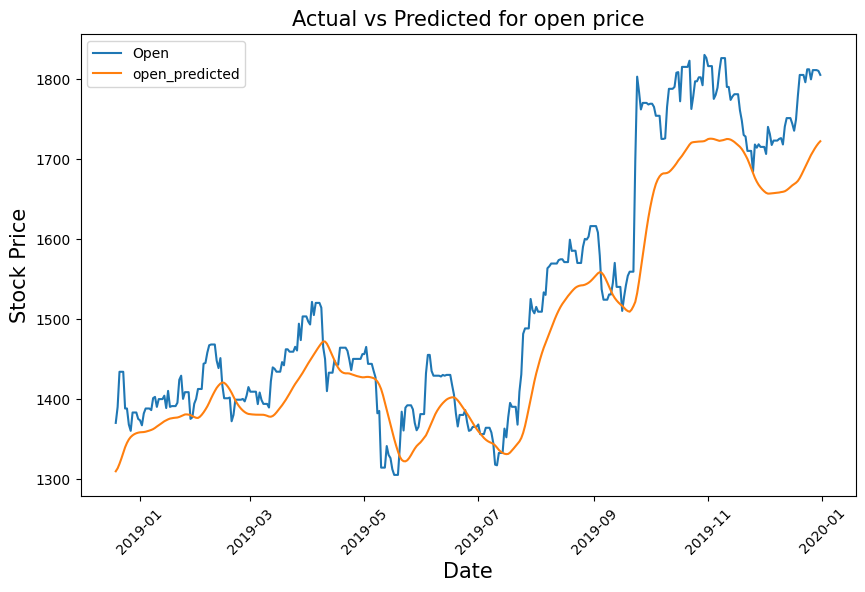

In [111]:
new_df[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

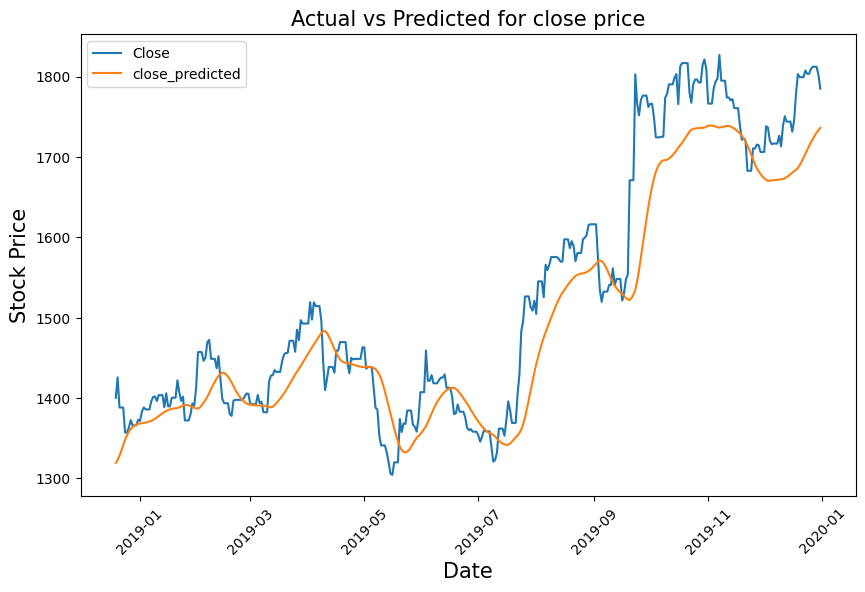

In [112]:
new_df[['Close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()